# Defeating Noisy Gradients: Using PGD with Expectation over Transformation (EoT)

<a target="_blank" href="https://colab.research.google.com/github/unica-mlsec/mlsec/blob/main/labs/05_defeating_noisy_gradients.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this tutorial, we are going to test the robustness of a defense that was specifically designed to resist gradient-based attacks.

Despite the efforts, however, this defense was later shown to be just *hiding* the adversarial examples rather than removing them. It was broken by an **adaptive** attack, *i.e.*, attacks that target the specific defense mechanism that is in place.

## The k-Winners-Take-All (k-WTA) Defense

This defense was proposed in Xiao et al. (2020). This defense replaces the usual activation layer of the DNNs (ReLU) with a k-WTA activation function.

As shown in the picture, the ReLU sets to zero the neurons that have a negative output, whereas the k-WTA sets to zero all weights except the top-k (optionally in absolute value, there are different possible configurations).

<img style="max-width: 300px; height: auto; " src="./assets/kWTA.png" />


This trick aims to break gradient descent by introducing $C_0$ discontinuities on the loss landscape. In this way, any gradient-based attack would fail in finding a consistent direction to minimize the loss.

In [ ]:
%%capture
try:
    import secmlt
    import foolbox
except ImportError:
    %pip install secml-torch[foolbox]
    
try:
    import robustbench
except ImportError:
    %pip install git+https://github.com/RobustBench/robustbench.git

!git clone https://github.com/unica-mlsec/mlsec
%cd mlsec/labs

In [2]:
%%capture
from pathlib import Path

import matplotlib.pyplot as plt
from secmlt.models.base_model import BaseModel
import torch
import torchvision
from robustbench.utils import download_gdrive
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD, PGDNative
from secmlt.metrics.classification import Accuracy
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.trackers import LossTracker
from torch.utils.data import DataLoader, Subset
from utils.models import SparseResNet18

In [3]:
pretrained_path = Path("models")
if not pretrained_path.exists():
    pretrained_path.mkdir(parents=True, exist_ok=True)

# key of a Google Drive file containing the pretrained model
MODEL_ID = "1Af_owmMvg1LxjITLE1gFUmPx5idogeTP"

gamma = 0.1  # sparsity ratio
filepath = pretrained_path / f"kwta_spresnet18_{gamma}_cifar_adv.pth"
if not filepath.exists():
    # utility function to handle google drive data
    download_gdrive(MODEL_ID, filepath)

# check out the model class in the imported module to see the implementation
# of this defense
model = SparseResNet18(sparsities=[gamma, gamma, gamma, gamma])

# check if CUDA is available
if not torch.cuda.is_available():
    state_dict = torch.load(filepath, map_location="cpu")
else:
    state_dict = torch.load(filepath)

model.load_state_dict(state_dict)
model.eval()

dataset_path = "data/datasets/"  # relative to this notebook's folder

cifar_10 = torchvision.datasets.CIFAR10(
    root=dataset_path, train=False, download=True, transform=torchvision.transforms.ToTensor()
)
cifar_10_subset = Subset(cifar_10, list(range(5)))
cifar_10_data_loader = DataLoader(cifar_10_subset, batch_size=128, shuffle=False)

classifier = BasePytorchClassifier(model)
print("Test accuracy: ", Accuracy()(classifier, cifar_10_data_loader))

Download started: path=models/kwta_spresnet18_0.1_cifar_adv.pth (gdrive_id=1Af_owmMvg1LxjITLE1gFUmPx5idogeTP)
Download finished: path=models/kwta_spresnet18_0.1_cifar_adv.pth (gdrive_id=1Af_owmMvg1LxjITLE1gFUmPx5idogeTP)


100%|██████████| 170498071/170498071 [00:08<00:00, 19587832.07it/s]


Extracting data/datasets/cifar-10-python.tar.gz to data/datasets/
Test accuracy:  tensor(1.)


We first attack the model with untargeted PGD $\ell_\infty$, $\varepsilon=0.03$, $\alpha=0.005$ and 50 steps.

In [4]:
num_steps = 100
epsilon = 8 / 255
step_size = 0.005
lb = 0.0
ub = 1.0
random_start = False
y_target = None
perturbation_model = LpPerturbationModels.LINF

pgd_foolbox = PGD(
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    perturbation_model=perturbation_model,
    backend=Backends.FOOLBOX,
    y_target=y_target,
    lb=lb,
    ub=ub,
    random_start=random_start,
)
adv_ds_fb = pgd_foolbox(classifier, cifar_10_data_loader)
print("Robust accuracy (PGD Foolbox): ", Accuracy()(classifier, adv_ds_fb))


Robust accuracy (PGD Foolbox):  tensor(1.)


First, attacking this model results in optimizing over a very noisy loss function. In fact, we are not able to see this with the Foolbox attack, but we can inspect the loss with our native implementation. Moreover, our native implementation takes the best point instead of the last, therefore avoiding silent failures (Pintor, 2022).
This might result in a better estimation already, as our attack tracks whether any of the iterates inside the optimization loop are succesfully adversarial, keeping the best points found.

<img style="max-width: 300px; height: auto; " src="./assets/best_point.png" />

In [5]:
pgd = PGD(
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    perturbation_model=perturbation_model,
    backend=Backends.NATIVE,
    trackers=[LossTracker()],
    y_target=y_target,
    lb=lb,
    ub=ub,
    random_start=random_start,
)
adv_ds = pgd(classifier, cifar_10_data_loader)
print("Robust accuracy (PGD Native): ", Accuracy()(classifier, adv_ds))

Robust accuracy (PGD Native):  tensor(0.6000)


Did it work?
Probably not as expected... But the model is not as robust as it seems.
Let's try to visualize the loss of the attack on one single sample.

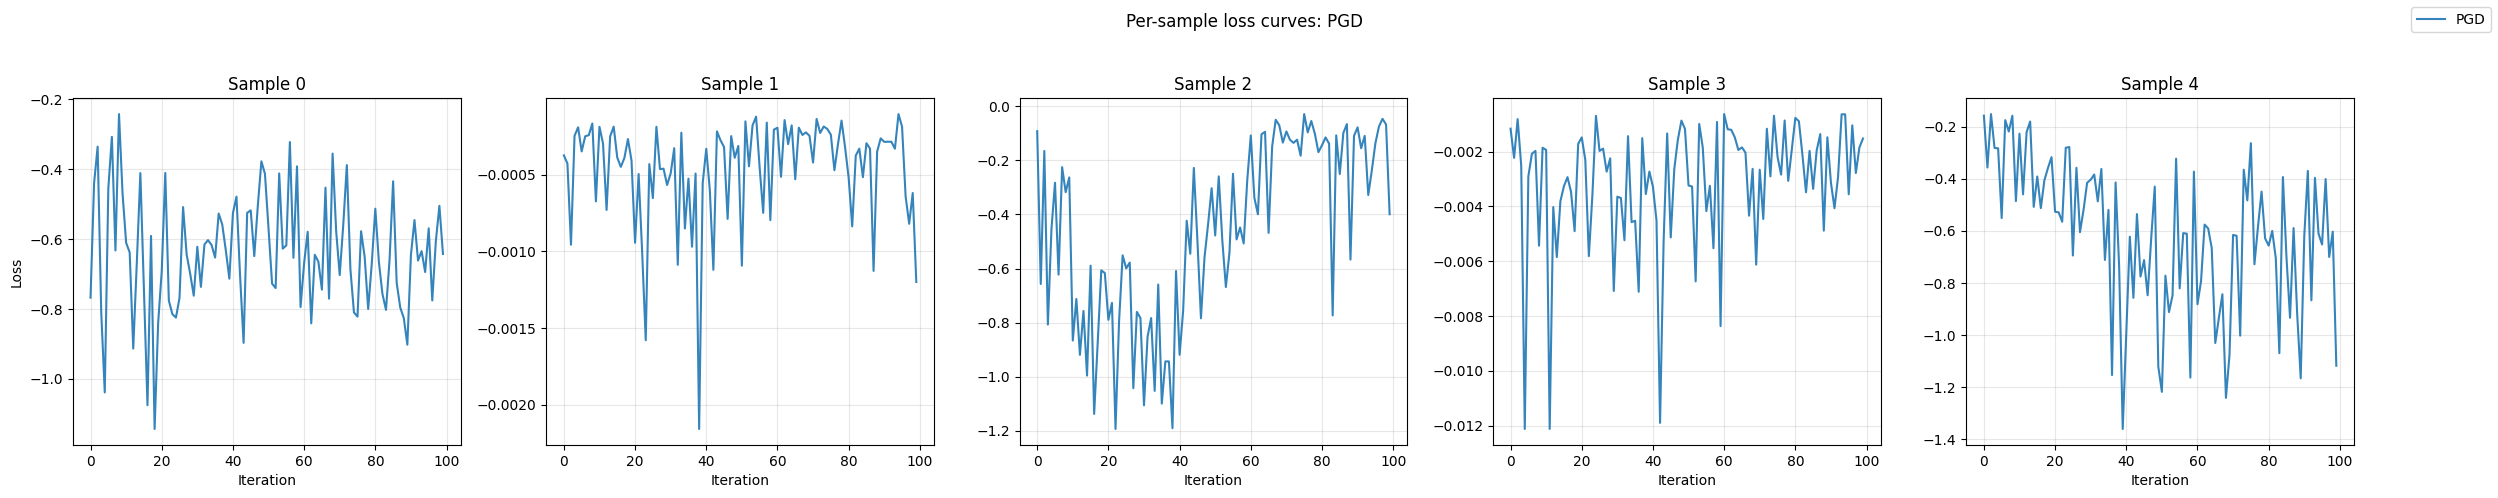

In [6]:
# get loss
loss_pgd = pgd.trackers[0].get()       # shape [num_samples, num_steps]

num_samples = loss_pgd.shape[0]

# create subplots (one row, multiple columns)
fig, axes = plt.subplots(
    nrows=1,
    ncols=num_samples,
    figsize=(5 * num_samples, 5),
)

if num_samples == 1:
    axes = [axes]  # ensure iterable if single sample

for i, ax in enumerate(axes):
    ax.plot(loss_pgd[i], linestyle="-", alpha=0.9, label="PGD")
    ax.set_title(f"Sample {i}")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Loss")
for ax in axes:
    ax.set_xlabel("Iteration")

fig.suptitle("Per-sample loss curves: PGD")

# get only one legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()

The attack is not working because the optimization is not really improving the objective.
This is caused by gradient obfuscation.
As explained before, the model is indeed causing the loss landscape to become extremely noisy (this is shown also in the paper).

![landscape](./assets/kWTA_landscape.png)

How to fix this? We need an **adaptive attack** (Tramer, 2020).

Open the referenced paper and find the model that we just attacked and read through the section (hint: go to https://arxiv.org and find the paper there).
What causes the model to be strong against gradient-based attacks?
How did the authors of Tramer et al. (2020) break the defense?

## Adaptive attack for k-WTA

We are now using an implementation of the attack in Tramer et al. (2020) (adapted for SecML-Torch).

The attack estimates the gradient by querying the model (without computing the white-box gradient), and by computing a finite-difference approximation on sets of points sampled in a neighborhood of the sample.
The smoother approximation is then obtained by averaging the direction of all these estimated gradients.

This approximation has a cost: it has to query the model multiple time for each step of the attack, as the gradient has to be estimated locally each time.


Note: the following lines take a long time to complete the attack. For this reason, they are commented. Feel free to uncomment to check how the attack runs and finds better results than the baseline PGD. 

We will load the plot directly to display the results while avoiding recompiling in our docs.

In [7]:

from secmlt.adv.evasion.modular_attacks.eot_gradient import EoTGradientMixin

# re-initialize trackers
trackers = [LossTracker()]


# custom pgd with EoT
class PGDEoT(EoTGradientMixin,PGDNative):
    ...  # inherits everything from PGDNative and EoTGradientMixin
    


pgd_eot = PGDEoT(
    eot_samples=300,
    eot_radius=0.03,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    perturbation_model=perturbation_model,
    backend=Backends.NATIVE,
    trackers=[LossTracker()],
    y_target=y_target,
    lb=lb,
    ub=ub,
    random_start=random_start,
)

# uncomment for running the attack (it takes a long time)
# adv_ds_eot = pgd_eot(classifier, cifar_10_data_loader)
# print("Robust accuracy (PGD EoT): ", Accuracy()(classifier, adv_ds_eot))


In [8]:
# uncomment to plot the losses after running the attack

# # get loss
# loss_pgd = pgd.trackers[0].get()       # shape [num_samples, num_steps]
# loss_eot = pgd_eot.trackers[0].get()   # same shape

# num_samples = loss_pgd.shape[0]

# # create subplots (one row, multiple columns)
# fig, axes = plt.subplots(
#     nrows=1,
#     ncols=num_samples,
#     figsize=(5 * num_samples, 5),
# )

# if num_samples == 1:
#     axes = [axes]  # ensure iterable if single sample

# for i, ax in enumerate(axes):
#     ax.plot(loss_pgd[i], linestyle="-", alpha=0.9, label="PGD")
#     ax.plot(loss_eot[i], linestyle="--", alpha=0.9, label="PGD EoT")
#     ax.set_title(f"Sample {i}")
#     ax.grid(alpha=0.3)

# axes[0].set_ylabel("Loss")
# for ax in axes:
#     ax.set_xlabel("Iteration")

# fig.suptitle("Per-sample loss curves: PGD vs PGD EoT")

# # get only one legend for the entire figure
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="upper right")

# plt.tight_layout(rect=[0, 0, 0.95, 0.95])



```text
Robust accuracy (PGD EoT):  tensor(0.2000)
```

![pgd-vs-eot](./assets/adaptive_attacks_loss_curves.png)

## References
* Maura Pintor, Luca Demetrio, Angelo Sotgiu, Ambra Demontis, Nicholas Carlini, Battista Biggio, and Fabio Roli. Indicators of attack failure: debugging and improving optimization of adversarial examples. Advances in Neural Information Processing Systems, 35:23063–23076, 2022.
* Florian Tramer, Nicholas Carlini, Wieland Brendel, and Aleksander Madry. On adaptive attacks to adversarial example defenses. Advances in neural information processing systems, 33:1633–1645, 2020.
* Chang Xiao, Peilin Zhong, and Changxi Zheng. Enhancing adversarial defense by k-winners-take-all. In International Conference on Learning Representations. 2020.